In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! unzip gtsrb-german-traffic-sign.zip -d dataset

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) # allow gpu usage

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
train_X = []
train_y = []
labels = []
counts = []
min_label_count = 0

for i in range(0,43):
    n = str(i)
    train_path = "dataset/Train/" + n
    label = [0 for i in range(0, 43)]
    label[i] = 1
    file_names = os.listdir(train_path)

    if len(file_names) < min_label_count:
        continue

    for file_name in file_names:
        img = cv.imread(train_path + "/" + file_name)
        img = cv.resize(img, (40,40))
        train_X.append(img)
        train_y.append(label)

    labels.append(i)
    counts.append(len(file_names))

train_X = np.asarray(train_X, dtype = "float32")
train_X = train_X/255
train_y = np.asarray(train_y, dtype= "float32")

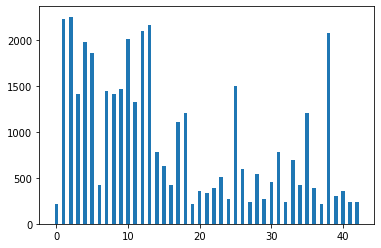

Number of classes = 43
Label range  = 0 to 42
Max count = 2250
Min count = 210


In [ ]:
plt.bar(labels,counts,width=0.5)
plt.show()

print(f"Number of classes = {len(labels)}")
print(f"Label range  = {min(labels)} to {max(labels)}")
print(f"Max count = {max(counts)}")
print(f"Min count = {min(counts)}")

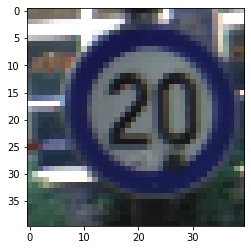

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


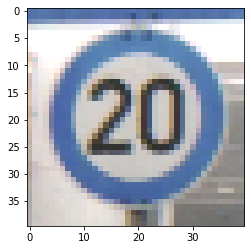

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


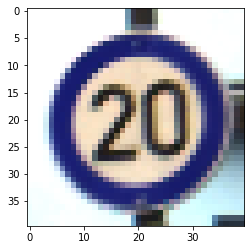

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


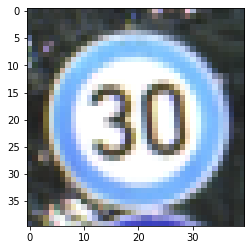

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
plt.imshow(train_X[0])
plt.show()
print(train_y[0])

plt.imshow(train_X[1])
plt.show()
print(train_y[1])

plt.imshow(train_X[2])
plt.show()
print(train_y[2])

plt.imshow(train_X[400])
plt.show()
print(train_y[400])


In [ ]:
test_X = []
test_y = []

test_directory = "dataset/Test"
df = pd.read_csv("dataset/Test.csv")
dct = dict(zip(df.Path, df.ClassId))

for filename in os.listdir(test_directory):
    if filename.endswith(".png"):
        classId = dct[f'Test/{filename}']
        if classId not in labels:
            continue

        img = cv.imread(test_directory + "/" + filename)
        img = cv.resize(img, (40,40))
        label = [0 for i in range(0, 43)]
        label[classId]  = 1
        test_X.append(img)
        test_y.append(label)

test_X = np.asarray(test_X, dtype = "float32")
test_X = test_X/255
test_y = np.asarray(test_y, dtype= "float32")

In [ ]:
test_X, validation_X, test_y, validation_y = train_test_split(test_X, test_y, test_size=0.5)

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(validation_X.shape)
print(validation_y.shape)
print(test_X.shape)
print(test_y.shape)

(39209, 40, 40, 3)
(39209, 43)
(6315, 40, 40, 3)
(6315, 43)
(6315, 40, 40, 3)
(6315, 43)


In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=9, padding='same', activation='relu',
                 input_shape=train_X.shape[1:]))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=7, padding='same', activation='relu',
                 input_shape=train_X.shape[1:]))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=5, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(43, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy'])
history = model.fit(train_X, train_y,
              batch_size= 16,
              epochs=10,
              validation_data= (validation_X, validation_y),
              shuffle=True)

Epoch 1/10
2451/2451 [==============================] - 13s 5ms/step - loss: 1.7740 - accuracy: 0.5016 - val_loss: 0.7571 - val_accuracy: 0.7799
Epoch 2/10
2451/2451 [==============================] - 12s 5ms/step - loss: 0.4146 - accuracy: 0.8699 - val_loss: 0.4220 - val_accuracy: 0.8809
Epoch 3/10
2451/2451 [==============================] - 12s 5ms/step - loss: 0.1883 - accuracy: 0.9443 - val_loss: 0.3484 - val_accuracy: 0.9028
Epoch 4/10
2451/2451 [==============================] - 12s 5ms/step - loss: 0.1099 - accuracy: 0.9671 - val_loss: 0.3035 - val_accuracy: 0.9237
Epoch 5/10
2451/2451 [==============================] - 13s 5ms/step - loss: 0.0749 - accuracy: 0.9785 - val_loss: 0.2619 - val_accuracy: 0.9319
Epoch 6/10
2451/2451 [==============================] - 13s 5ms/step - loss: 0.0555 - accuracy: 0.9832 - val_loss: 0.3394 - val_accuracy: 0.9267
Epoch 7/10
2451/2451 [==============================] - 13s 5ms/step - loss: 0.0428 - accuracy: 0.9868 - val_loss: 0.3419 - val_ac

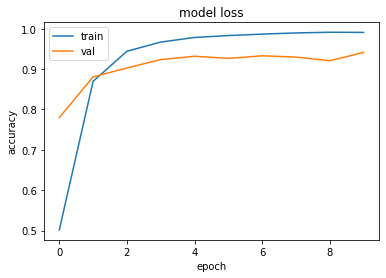

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

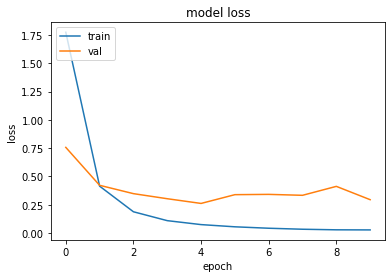

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_X, test_y)

198/198 [==============================] - 1s 3ms/step - loss: 0.2943 - accuracy: 0.9424


[0.29430028796195984, 0.942359447479248]